## 제 1회 D.COMpetition 참여를 환영합니다!
본격적인 대회 참여에 앞서 **베이스라인(baseline)** 코드를 소개합니다.  
베이스라인 코드를 통해 대회 진행에 필요한 전체적인 감을 익힐 수 있습니다.  
해당 코드를 바탕으로 여러분들이 배운 내용을 활용하여 우수한 실력을 뽐내보세요!  
대회를 진행하면서 궁금하거나 도움이 필요하면 언제나 대회 운영진(**서주원([JJuOn](https://github.com/JJuOn))**, **송용우([FacerAin](https://github.com/FacerAin)))**에게 물어보시기 바랍니다 :)


## 0. Prepare Environment
본격적인 개발에 앞서 필요한 환경을 구축합니다. 다음과 같은 순서로 구성됩니다.
1. 라이브러리 설치
2. 구글 드라이브 연결
3. 라이브러리 불러오기
4. 데이터파일 복사해서 불러오기
5. CUDA 세팅하기
6. 랜덤 시드 설정하기

### 라이브러리 설치
필요한 라이브러리를 설치합니다.  
노트북 환경에서는 **느낌표(!)를 이용하여 셀 명령어를 실행**시킬 수 있습니다.

In [1]:
!pip install timm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.1 MB/s 


In [2]:
!nvidia-smi

Fri Aug 12 13:34:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount Google Drive
자신 계정의 구글 드라이브에 마운트합니다.  
코랩이 구글 드라이브의 파일들에 접근할 수 있도록 합니다.  

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Import Library
필요한 라이브러리를 불러옵니다.

In [4]:
import torch
import timm
import os
import random

import math

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from datetime import datetime

from torch.optim.lr_scheduler import _LRScheduler

%matplotlib inline

### Copy data files
우선 **캐글에서 다운받은 데이터 파일(data.zip, sample_submission.csv)**을 **해당 구글 드라이브 경로(MyDrive/dcompetition/)**에 올려주세요.  
**(!!중요!! 이때 data 폴더는 zip 파일로 압축해서 올려주세요!)**

그리고 데이터를 불러오기 편하도록 구글 드라이브 상의 데이터 파일들을 현재 위치로 복사하고 압축을 해제합니다.

In [5]:
!cp /content/drive/MyDrive/dcompetition/data.zip .
!cp /content/drive/MyDrive/dcompetition/sample_submission.csv .
!unzip data.zip -d .

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./train/Siberian_husky/n02110185_7980.jpg  
  inflating: ./train/Siberian_husky/n02110185_8005.jpg  
  inflating: ./train/Siberian_husky/n02110185_815.jpg  
  inflating: ./train/Siberian_husky/n02110185_8154.jpg  
  inflating: ./train/Siberian_husky/n02110185_8162.jpg  
  inflating: ./train/Siberian_husky/n02110185_8327.jpg  
  inflating: ./train/Siberian_husky/n02110185_8360.jpg  
  inflating: ./train/Siberian_husky/n02110185_8397.jpg  
  inflating: ./train/Siberian_husky/n02110185_8564.jpg  
  inflating: ./train/Siberian_husky/n02110185_8600.jpg  
  inflating: ./train/Siberian_husky/n02110185_8708.jpg  
  inflating: ./train/Siberian_husky/n02110185_8748.jpg  
  inflating: ./train/Siberian_husky/n02110185_8749.jpg  
  inflating: ./train/Siberian_husky/n02110185_8860.jpg  
  inflating: ./train/Siberian_husky/n02110185_8923.jpg  
  inflating: ./train/Siberian_husky/n02110185_9001.jpg  
  inflating: ./train/Siberian_husky/n02110185_9086.jp

### Cuda Setting
가용한 GPU가 있다면 **GPU 자원을 활용**할 수 있도록 CUDA를 활성화합니다.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Set Random Seed
모델을 구동할 때마다 다른 결과가 나오는 것을 방지하기 위해  
**랜덤 시드 값을 고정**합니다.

In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. 데이터 전처리하기
학습에 필요한 데이터를 전처리해봅시다! 데이터셋을 정의하고, 정제하는 과정을 거칩니다. 순서는 다음과 같습니다.
1. Define Dataset Class
2. Define Data Transform
3. Make Train/Valid Dataset
4. Make DataLoader

### Define Dataset Class
Pytorch에서는 사용자가 편하게 데이터셋을 관리할 수 있도록 Dataset 클래스를 제공합니다.  
**Dataset 클래스를 상속받아 사용자 정의 Dataset 클래스를 만들 수 있습니다.**  
자세한 내용은 [파이토치 공식 레퍼런스 문서](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)를 참고해주세요.


In [8]:
class CustomSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.indices = self.subset.indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


class TestDataset(Dataset):
    def __init__(self, root='./test', transform=None):
        self.root = root
        self.data = os.listdir(self.root)
        self.data = sorted(self.data)
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.data[idx]))
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.data)


### Define Data Transform
torchvision.transforms 모듈을 통해 편리하게 데이터 **transforming과 augmentation**을 정의할 수 있습니다.  
자세한 내용은 관련 [공식 도큐먼트 문서](https://pytorch.org/vision/stable/transforms.html)를 참고해주세요.


In [9]:
from torchvision.transforms.transforms import RandomRotation
transform = {
    'train': transforms.Compose([transforms.Resize((256,256)),
                                 transforms.RandomResizedCrop((224,224)),
                                 transforms.ColorJitter(brightness=(0.8,1.3), contrast=0.5, saturation=0.5), #.밝기,대비,채도 변경
                                 transforms.RandomRotation(15),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.476, 0.440, 0.384], [0.229, 0.224, 0.220]), #dataset 정규화값
                                 transforms.RandomErasing() #무작위 구역 삭제
                                 ]),
             
    'valid': transforms.Compose([transforms.Resize((256,256)),
                                 transforms.CenterCrop((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.476, 0.440, 0.384], [0.229, 0.224, 0.220])
                                 ]),
}

### Make Train/Valid Dataset
앞서 정의한 Dataset Class와 Transforms를 활용하여 Train, Valid 데이터셋을 만듭니다.  
이때 Train/Valid 비율은 8:2로 하였습니다.

In [10]:
all_data = ImageFolder(root='./train')

train_ratio = 0.8
train_data_len = int(len(all_data) * train_ratio)
valid_data_len = len(all_data) - train_data_len
train_data, valid_data = random_split(all_data, [train_data_len, valid_data_len])

train_data = CustomSubset(train_data, transform['train'])
valid_data = CustomSubset(valid_data, transform['valid'])

### Make DataLoader
Pytorch에서는 데이터셋 안의 샘플들에 쉽게 접근할 수 있도록 **순회 가능한 객체(iterable)인 DataLoader를 제공**합니다.  
이를 통해 모델 학습간 보다 쉽게 데이터 샘플에 접근하여 사용할 수 있습니다.
또한 이때 데이터셋의 배치 크기를 정의하거나 무작위 섞기(shuffle) 유무를 설정할 수 있습니다.

In [11]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False,drop_last=True)

## EDA (Exploratory Data Analysis)
본격적으로 모델을 만들기 전에, **다루고자 하는 데이터가 어떤 특징을 가졌는지 탐색하고 이해하는 것은 매우 중요합니다.**
이 과정을 **탐색적 데이터 분석(EDA)**라고 합니다.
이번 베이스라인 코드에서는 이미지가 어떻게 생겼는지, 개수는 어떠한지 간단하게 파악해보도록 합니다.  
실제 대회에서는 반드시 EDA를 꼼꼼히 진행하여 데이터를 확실히 이해하고 진행할 수 있도록 합시다!

### Train/Dev 데이터 개수

In [12]:
print("Train/Valid Data Size: " + str(len(all_data)))
print("Train Data Size: " + str(train_data_len))
print("Valid Data Size: " + str(valid_data_len))

Train/Valid Data Size: 18180
Train Data Size: 14544
Valid Data Size: 3636


### Class 개수

In [13]:
print("Number of Classes: " + str(len(all_data.classes)))
print(all_data.classes[:10])

Number of Classes: 120
['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


### Class 별 Sample 개수

{'Affenpinscher': 130, 'Afghan_hound': 219, 'African_hunting_dog': 149, 'Airedale': 182, 'American_staffordshire_terrier': 144, 'Appenzeller': 131, 'Australian_terrier': 176, 'Basenji': 189, 'Basset': 155, 'Beagle': 175, 'Bedlington_terrier': 162, 'Bernese_mountain_dog': 198, 'Black-and-tan_coonhound': 139, 'Blenheim_spaniel': 168, 'Bloodhound': 167, 'Bluetick': 151, 'Border_collie': 130, 'Border_terrier': 152, 'Borzoi': 131, 'Boston_bull': 162, 'Bouvier_des_flandres': 130, 'Boxer': 131, 'Brabancon_griffon': 133, 'Briard': 132, 'Brittany_spaniel': 132, 'Bull_mastiff': 136, 'Cairn': 177, 'Cardigan': 135, 'Chesapeake_bay_retriever': 147, 'Chihuahua': 132, 'Chow': 176, 'Clumber': 130, 'Cocker_spaniel': 139, 'Collie': 133, 'Curly-coated_retriever': 131, 'Dandie_dinmont': 160, 'Dhole': 130, 'Dingo': 136, 'Doberman': 130, 'English_foxhound': 137, 'English_setter': 141, 'English_springer': 139, 'Entlebucher': 182, 'Eskimo_dog': 130, 'Flat-coated_retriever': 132, 'French_bulldog': 139, 'German

<BarContainer object of 120 artists>

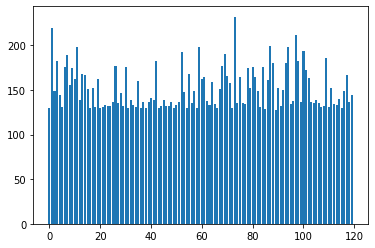

In [14]:
items = all_data.class_to_idx.items()
idx2class = {v:k for k, v in items}
count_dict = {k:0 for k, v in items}
for item in all_data:
    label = item[1]
    count_dict[idx2class[label]] += 1

print(count_dict)
plt.bar(np.arange(len(count_dict)), count_dict.values())

### 학습데이터 시각화

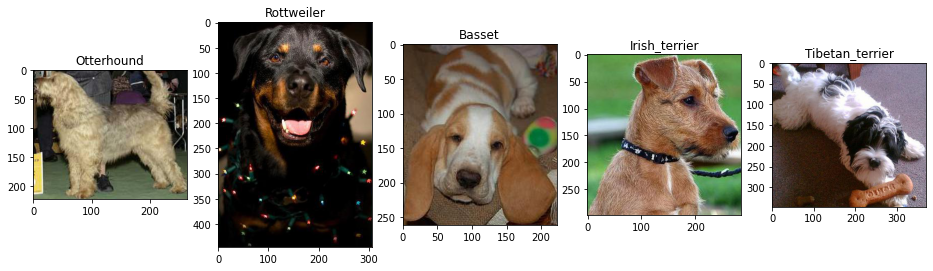

In [15]:
fig = plt.figure(figsize=(16, 16))
axes = []
idx_to_visualize = random.sample(list(range(len(all_data))), 5)
for i,idx in enumerate(idx_to_visualize):
    image, label = all_data[idx]
    axes.append(fig.add_subplot(1, 5, i+1))
    axes[i].set_title(idx2class[label])
    axes[i].imshow(image)
plt.show()

### 학습데이터 전처리 결과

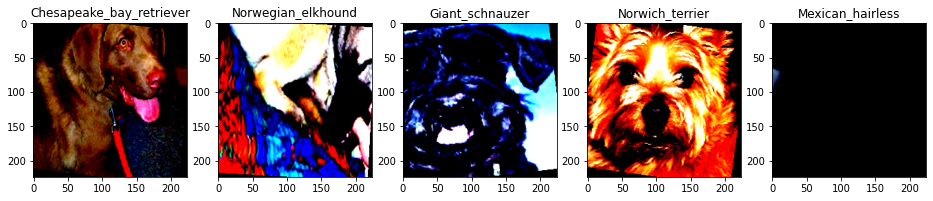

In [16]:
fig = plt.figure(figsize=(16, 16))
axes = []
idx_to_visualize = random.sample(list(range(len(train_data))), 5)
for i,idx in enumerate(idx_to_visualize):
    image, label = train_data[idx]
    axes.append(fig.add_subplot(1, 5, i+1))
    axes[i].set_title(idx2class[label])
    axes[i].imshow(image.permute(1,2,0))
plt.show()

## Make Model 
 **model - efficientnet_b0** 

 **optimizer - AdamW**
 

In [17]:
# for checking the number of parameters
# do not modify below
def param_check(model):
    total = 0
    for param in model.parameters():
        total += torch.numel(param)
    return total < 15000000

In [18]:
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=120)
# check the number of parameters
assert param_check(model)

optimizer = optim.AdamW(model.parameters(), lr=0, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

## Learning scheduler 
 **Custom CosineAnnealingWarmUpRestarts** 

https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py

In [19]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [20]:
#50epoch 주기, max learning rate 0.005, warmup start 5epoch, max값 감소없음
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=0.005,  T_up=5, gamma=1.0)

## 학습 진행하기
모델 학습(train)과 검증(validation)을 진행해봅시다.

In [21]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_every=10):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_acc = -np.inf
    start_time = datetime.now()
    try:
        for epoch in range(num_epochs):
            train_loss = 0
            train_acc = 0
            processed = 0
            model.train()
            # training step
            for i, (data, label) in enumerate(train_loader):
                data, label = data.to(device), label.to(device)
                pred = model(data)
                loss = criterion(pred, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == label).item()
                processed += data.size(0)
                if (i % print_every == 0) or (i == len(train_loader) - 1):
                    print(f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(train_loader) * 100:.2f}%)\ttrain loss: {train_loss / processed:.4f}\ttrain acc: {train_acc / processed * 100:.4f}%\ttime elapsed: {datetime.now() - start_time}')
            train_losses.append(train_loss / processed)
            train_accs.append(train_acc / processed)
            print("="*90)

            scheduler.step()

            # validation step
            valid_loss = 0
            valid_acc = 0
            processed = 0
            model.eval()
            with torch.no_grad():
                for i, (data, label) in enumerate(valid_loader):
                    data, label = data.to(device), label.to(device)
                    pred = model(data)
                    loss = criterion(pred, label)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == label).item()
                    processed += data.size(0)
                    if (i % print_every == 0) or (i == len(valid_loader) - 1):
                        print(f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(valid_loader) * 100:.2f}%)\tvalid loss: {valid_loss / processed:.4f}\tvalid acc: {valid_acc / processed * 100:.4f}%\ttime elapsed: {datetime.now() - start_time}')
                if valid_acc / processed > best_acc:
                    best_acc = valid_acc / processed
                    torch.save(model.state_dict(), 'model_best.pth')
                
                torch.save(model.state_dict(), 'model_last.pth')
                valid_losses.append(valid_loss / processed)
                valid_accs.append(valid_acc / processed)
            print("="*90,"lr = ",optimizer.param_groups[0]['lr'])
        return train_losses, train_accs, valid_losses, valid_accs
    except KeyboardInterrupt:
        return train_losses, train_accs, valid_losses, valid_accs

In [22]:
train_losses, train_accs, valid_losses, valid_accs = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=300, device=device)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch [36/299](75.00%)	valid loss: 1.4123	valid acc: 59.1146%	time elapsed: 1:46:57.106256
Epoch [36/299](100.00%)	valid loss: 1.4015	valid acc: 59.3192%	time elapsed: 1:47:01.242450
========================================================================================== lr =  0.0009608463116858543
Epoch [37/299](0.88%)	train loss: 1.8344	train acc: 46.8750%	time elapsed: 1:47:02.797999
Epoch [37/299](9.73%)	train loss: 2.0277	train acc: 44.8864%	time elapsed: 1:47:16.704166
Epoch [37/299](18.58%)	train loss: 1.9837	train acc: 46.2054%	time elapsed: 1:47:30.499888
Epoch [37/299](27.43%)	train loss: 1.9887	train acc: 45.9677%	time elapsed: 1:47:44.226704
Epoch [37/299](36.28%)	train loss: 1.9764	train acc: 46.2652%	time elapsed: 1:47:58.059210
Epoch [37/299](45.13%)	train loss: 1.9719	train acc: 46.4767%	time elapsed: 1:48:11.895429
Epoch [37/299](53.98%)	train loss: 1.9634	train acc: 46.6060%	time elapsed: 1:48:25.681204
Epoch [37/299](62.83%)	trai

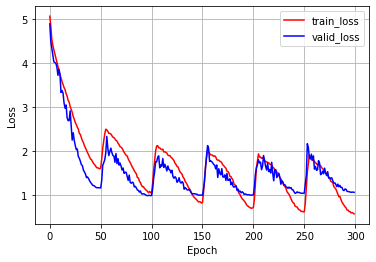

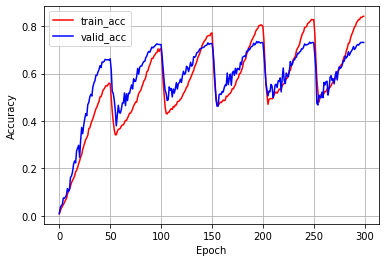

In [23]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(train_losses)), train_losses, label='train_loss', color='red')
plt.plot(range(len(valid_losses)), valid_losses, label='valid_loss', color='blue')
plt.legend()
plt.grid()
plt.show()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(len(train_accs)), train_accs, label='train_acc', color='red')
plt.plot(range(len(valid_accs)), valid_accs, label='valid_acc', color='blue')
plt.legend()
plt.grid()
plt.show()

In [24]:
max(valid_accs)

0.7354910714285714

In [25]:
max(train_accs)

0.8418141592920354

학습 metric을 통해 모델의 학습이 원활하게 이루어졌는지, 과적합(Overfitting)은 없었는지 평가해봅시다.  
부족한 부분이 있다면 어디서 어떻게 개선할 수 있을까요?

## Test Model
학습한 모델을 Test 데이터셋으로 구동해봅시다.
실행 결과는 submission.csv에 담아 Kaggle에 제출해주세요. 


In [26]:
model.load_state_dict(torch.load('model_best.pth'))
model = model.to(device)

valid data 오답, 정답률

(predict) Miniature_schnauzer -> (correct) Standard_schnauzer
(predict) Appenzeller -> (correct) Bernese_mountain_dog
(predict) Shih-tzu -> (correct) Lhasa
(predict) Miniature_pinscher -> (correct) German_shepherd
(predict) Great_dane -> (correct) Mexican_hairless
(predict) German_shepherd -> (correct) Siberian_husky
(predict) Lhasa -> (correct) Tibetan_terrier
(predict) Lhasa -> (correct) Sealyham_terrier
(predict) Norwich_terrier -> (correct) Cairn
(predict) Great_pyrenees -> (correct) Clumber
(predict) American_staffordshire_terrier -> (correct) Staffordshire_bullterrier
(predict) Soft-coated_wheaten_terrier -> (correct) Tibetan_terrier
(predict) Scottish_deerhound -> (correct) Whippet
(predict) Cairn -> (correct) Norfolk_terrier
(predict) Border_terrier -> (correct) Soft-coated_wheaten_terrier
(predict) Norfolk_terrier -> (correct) Cairn
(predict) Shetland_sheepdog -> (correct) Collie
(predict) Whippet -> (correct) Pug
(predict) Appenzeller -> (correct) Basenji
(predict) Labrador_r

<BarContainer object of 120 artists>

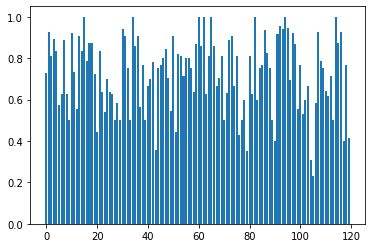

In [27]:
items = all_data.class_to_idx.items()
idx2class = {v:k for k, v in items}
count_dict = {k:0 for k, v in items}
correct_dict = {k:0 for k, v in items}

correct = 0
not_correct = 0
model.eval()
with torch.no_grad():
    for i, (data, label) in enumerate(valid_loader):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        for i in range(64):
          if all_data.classes[pred[i].max(dim=0)[1]] == all_data.classes[label[i]]:
            correct += 1
            correct_dict[all_data.classes[label[i]]] += 1
          else:
            not_correct += 1
            print("(predict)",all_data.classes[pred[i].max(dim=0)[1]],"->","(correct)",all_data.classes[label[i]])
          count_dict[all_data.classes[label[i]]] += 1

print("correct = ",correct," / not_correct = ",not_correct)
print(count_dict)
print(correct_dict)
for i in range(120):
  count_dict[all_data.classes[i]] = correct_dict[all_data.classes[i]] / count_dict[all_data.classes[i]]
print(count_dict)
plt.bar(np.arange(len(count_dict)), count_dict.values())

In [28]:
test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.CenterCrop((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.476, 0.440, 0.384], [0.229, 0.224, 0.220])])

test_data = TestDataset(root='./test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [29]:
def test(model, test_loader, device):
    preds = None
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            if preds is None:
                preds = pred.argmax(1)
            else:
                preds = torch.cat([preds, pred.argmax(1)], dim=0)
    return preds

In [30]:
preds = test(model, test_loader, device)
submission = pd.read_csv('sample_submission.csv')
submission['Category'] = preds.cpu().numpy()
submission.to_csv('drive/MyDrive/dcompetition/submission4.csv', index=False)